In [16]:
# Cálculo de isoyetas y polígonos de thiessen.

import numpy as np
import pandas as pd

from scipy import spatial

from matplotlib import pyplot as plt

import geopandas as gpd
import shapely as shp

In [17]:
# Dirección de los datos.
path = "../Material/Clases/Clase 11/"

# Nombre de la cuenca.
nombres_sub = "RH19Be_subc.shp"

# Datos de estaciones.
nombre_e = "Estaciones_Guerrero_1980.csv"

In [18]:
# Abrimos la subcuenca.
Subcuenca = gpd.read_file(path + nombres_sub)

# A coordenadas UTM 14N (m).
Subcuenca = Subcuenca.to_crs(32614)

# Abrimos las estaciones ubicadas en guerrero.
df = pd.read_csv(path + nombre_e, index_col = "NUMERO" )

# Creamos un punto con las coordenadas.
# Vacío.
df["geometry"] = None
df["geometry"] = gpd.points_from_xy(df["LONGITUD"], df["LATITUD"])

# Creamos un GeoDataFrame.
Estaciones = gpd.GeoDataFrame(df, geometry = "geometry", crs = 4326)
# A coordenadas UTM 14N (m).
Estaciones = Estaciones.to_crs(32614)

# Actualizamos x, y.
Estaciones["x"] = Estaciones.centroid.x
Estaciones["y"] = Estaciones.centroid.y

# Polígonos de Thiessen

In [19]:
# Agregamos estaciones virtuales en los límites de la extensión de la cuenca.

# Alejamos los puntos de la cuenca para que los nuevos polígonos de Thiessen
# no toquen la cuenca.
buffer = 20000
# Obtenemos la extensión de la cuenta.
bounds = Subcuenca.total_bounds
# Creamos los puntos en las esquinas e intermedio entre cada vértice
# agregando el valor del buffer.
bbox = [ [ bounds[0] - buffer, bounds[1] - buffer ],
         [ ( bounds[0] + bounds[2] ) / 2, bounds[1] - buffer ],
         [ bounds[2] + buffer, bounds[1] - buffer ],
         [ bounds[2] + buffer, ( bounds[1] + bounds[3] ) / 2 ],
         [ bounds[2] + buffer, bounds[3] + buffer ],
         [ ( bounds[0] + bounds[2] ) / 2, bounds[3] + buffer ],
         [ bounds[0] - buffer, bounds[3] + buffer ],
         [ bounds[0] - buffer, ( bounds[1] + bounds[3] ) / 2 ] ]
# Creamos una lista vacía con las geometrías de los puntos.
for i in range( len(bbox) ):
    bbox[i] = ( [f"B{i + 1}"] + [None] * ( Estaciones.shape[1] - 4 )
        + [shp.geometry.Point(bbox[i]), bbox[i][0], bbox[i][1] ] )
# Agregamos las estaciones virtuales.
Estaciones = pd.concat([Estaciones,
    pd.DataFrame(bbox, columns = Estaciones.columns)]
    ).reset_index( drop = True )


# Creamos los polígonos de Thiessen.
Thiessen = spatial.Voronoi( Estaciones[ ["x", "y"] ] )

# Extraemos los polígonos de Thiessen, los convertimos en geometrías
# de Shapely y los agregamos al geoDataFrame de Estaciones.

# Creamos los polígonos de Thiessen.
Thiessen = spatial.Voronoi( Estaciones[ ["x", "y"] ] )

# Extraemos los polígonos de Thiessen, los convertimos en geometrías
# de Shapely y los agregamos al geoDataFrame de Estaciones.

# Lista de geometrías de Shapely.
Poly_th = []

# Iteramos para cada lista de vértices que forman un polígono.
for i in Thiessen.point_region:

    # Creamos la lista de vértices.
    Ver_th = []

    # Saltamos las listas vacías.
    if len(Thiessen.regions[i]) == 0: pass
    else:
        if -1 in Thiessen.regions[i]:
            Poly_th.append( shp.geometry.Polygon( ) )
    
        # Agregamos cada vértice que corresponde al polígono de Thiessen.
        else:
            for j in Thiessen.regions[i]:
                Ver_th.append( Thiessen.vertices[j] )

            # Agregamos nuevamente el primer vértice para cerrar el polígono.
            Ver_th.append( Ver_th[0] )

            # Convertimos a geometría de shapely.
            Poly_th.append( shp.geometry.Polygon( Ver_th ) )

# Creamos una columna del GeoDataframe con los polígonos de Thiessen.
Estaciones["Thiessen"] = Poly_th
# Establecemos como la geometría de trabajo.
Estaciones = Estaciones.set_geometry("Thiessen")

# Retiramos las estaciones virtuales.
Estaciones = Estaciones.iloc[:-8].copy()
Estaciones["HP_1980"] = Estaciones["HP_1980"].astype(float)

In [20]:
# Áreas de influencia

# Calculamos el área de influencia de la estación como la parte
# de la cuenca que cae dentro de cada polígono de thiessen.
Estaciones[Subcuenca.loc[0, 'CVE_SUBCUE']] = Estaciones["Thiessen"
    ].intersection( Subcuenca.loc[0, "geometry"] )

# Establecemos el área de influencia como la geometría de trabajo.
Estaciones = Estaciones.set_geometry(Subcuenca.loc[0, 'CVE_SUBCUE'])

# Eliminamos las estaciones que no son relevantes para la cuenca.
subc_th = Estaciones[ ~ Estaciones.is_empty ].copy()
# Área de las áreas de influencia.
subc_th[f"{Subcuenca.loc[0, 'CVE_SUBCUE']}_AREA"] = subc_th.area

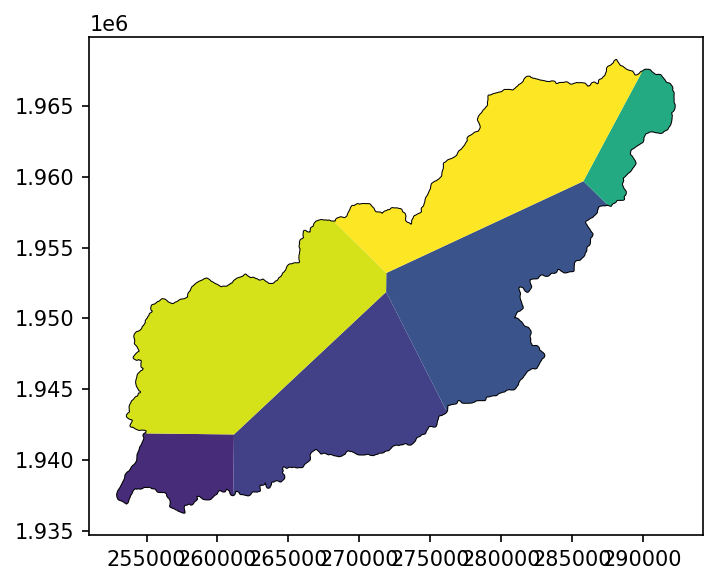

In [21]:
# Áreas de influencia

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 4)
fig.set_dpi(150) 

# Graficamos la cuenca.
Subcuenca.plot(ax = ax, color = "None", edgecolor = "k")
# Graficamos las áreas de influencia.
Estaciones.plot("HP_1980", ax = ax)

fig.tight_layout()
plt.show()

# Isoyetas

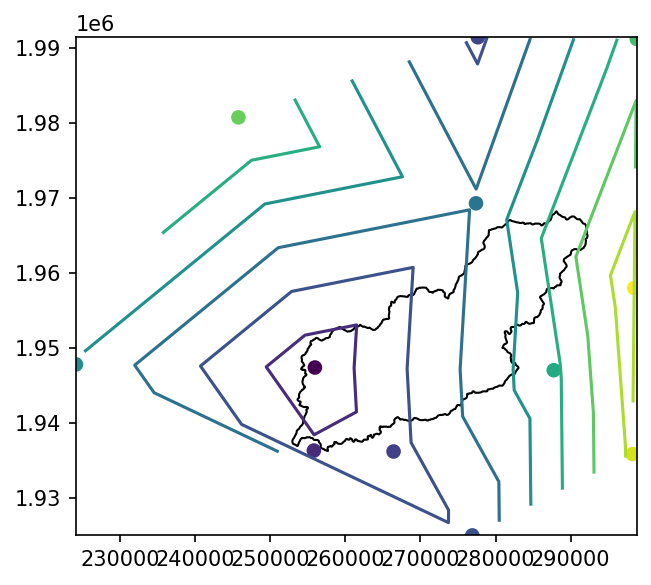

In [22]:
# Isoyetas

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 4)
fig.set_dpi(150) 

# Graficamos la cuenca.
Subcuenca.plot(ax = ax, color = "None", edgecolor = "k")
# Graficamos las estaciones.
Estaciones.set_geometry("geometry").plot("HP_1980", ax = ax)

# Graficamos las isoyetas y las guardamos en una variable.
isoyetas = ax.tricontour( Estaciones["x"],
    Estaciones["y"], Estaciones["HP_1980"] )

fig.tight_layout()
plt.show()

In [23]:
# Atributos de las isoyetas.

# Valores de cada isoyeta.
print( isoyetas.levels )

# Coordenadas de las isoyetas.
# allsegs es una lista de listas.
# allsegs[1] contiene todas las isoyetas de nivel levels[0].
# allsegs[2][0] es la primera isoyeta de nivel levels[1].
isoyetas.allsegs

[ 750.  900. 1050. 1200. 1350. 1500. 1650. 1800. 1950.]


[[],
 [array([[ 254600.33545736, 1951727.82919118],
         [ 261489.5903632 , 1953091.51253328],
         [ 261148.48180079, 1947354.52255686],
         [ 261462.84235565, 1941496.02594604],
         [ 255810.35672456, 1938444.39816142],
         [ 249431.37305316, 1947497.82060127],
         [ 254600.33545736, 1951727.82919118]])],
 [array([[ 278882.65808243, 1991431.8065039 ],
         [ 277607.82210509, 1987885.06836808],
         [ 276023.94365481, 1990901.50531276]]),
  array([[ 252818.3735017 , 1957557.48138489],
         [ 269017.43233436, 1960763.98005415],
         [ 268215.36625517, 1947274.30092041],
         [ 268745.01328675, 1937403.67532336],
         [ 273743.08107074, 1928400.93084312],
         [ 273724.65189621, 1926733.82193754],
         [ 246144.66364895, 1939833.23401225],
         [ 240664.32676751, 1947611.24497078],
         [ 252818.3735017 , 1957557.48138489]])],
 [array([[ 251091.50989144, 1936166.4071275 ],
         [ 234483.07323577, 1944054.76276126],


In [24]:
# Extraemos las isoyetas y las convertimos en curvas de Shapely.

# Lista con el nivel de las isoyetas repetido
# por cada isoyeta que haya en ese nivel.
hp_level = []
# Cantidad de isoyetas que tiene un nivel.
level_n  = []
# Curvas de cada isoyeta.
level_c  = []

# Iteramos para todos los grupos de isoyetas allsegs.
# Evitamos el primer y último grupo que están vacíos.
for i in range( len(isoyetas.allsegs[1:-1]) ):
    # Contamos la cantidad de isoyetas que hay en un grupo, lo agregamos
    # a la lista level_n e imprimimos los valores.
    level_n.append( len( isoyetas.allsegs[1 + i] ) )
    print(f"nivel {i}: {level_n[i]}")

    # Copiamos el nivel de la isoyeta tantas
    # veces como isoyetas haya en ese nivel.
    hp_level = hp_level + [isoyetas.levels[i]] * level_n[i]

    # Entramos en cada grupo i, que tiene una cantidad level_n[i]
    # de elementos dentro, convertimos cada elemento en una
    # geometría de shapely y lo metemos dentro de una lista
    # de una sola dimensión (como hacer flatten).
    for j in range( 0, level_n[i] ):
        level_c.append( shp.geometry.LineString(isoyetas.allsegs[i + 1][j]) )

print()
print(hp_level)

nivel 0: 1
nivel 1: 2
nivel 2: 2
nivel 3: 2
nivel 4: 2
nivel 5: 1
nivel 6: 1

[750.0, 900.0, 900.0, 1050.0, 1050.0, 1200.0, 1200.0, 1350.0, 1350.0, 1500.0, 1650.0]


In [25]:
# Creamos un DataFrame con los niveles de isoyetas.
df_is = pd.DataFrame(hp_level, columns = ["hp [mm]"])
# Agregamos las geometrías de shapely.
df_is["geometry"] = level_c
# Convertimos en un GeoDataFrame.
df_is = gpd.GeoDataFrame(df_is)
# Establecemos que hemos estado trabajando con coordenadas UTM 14N (m).
df_is = df_is.set_crs(32614)

df_is

,hp [mm],geometry
0,750.0,"LINESTRING (254600.335 1951727.829, 261489.590..."
1,900.0,"LINESTRING (278882.658 1991431.807, 277607.822..."
2,900.0,"LINESTRING (252818.374 1957557.481, 269017.432..."
3,1050.0,"LINESTRING (251091.510 1936166.407, 234483.073..."
4,1050.0,"LINESTRING (284670.375 1991369.350, 277419.745..."
5,1200.0,"LINESTRING (225172.646 1949509.497, 249254.450..."
6,1200.0,"LINESTRING (290458.091 1991306.894, 285542.802..."
7,1350.0,"LINESTRING (235553.211 1965292.325, 247472.488..."
8,1350.0,"LINESTRING (296245.808 1991244.437, 294728.184..."
9,1500.0,"LINESTRING (298656.347 1973948.302, 298747.581..."


In [26]:
# Isoyetas

# Graficamos las isoyetas.
map = df_is.explore()
# Estaciones.
Estaciones.set_geometry("geometry").explore(m = map, color = "red")

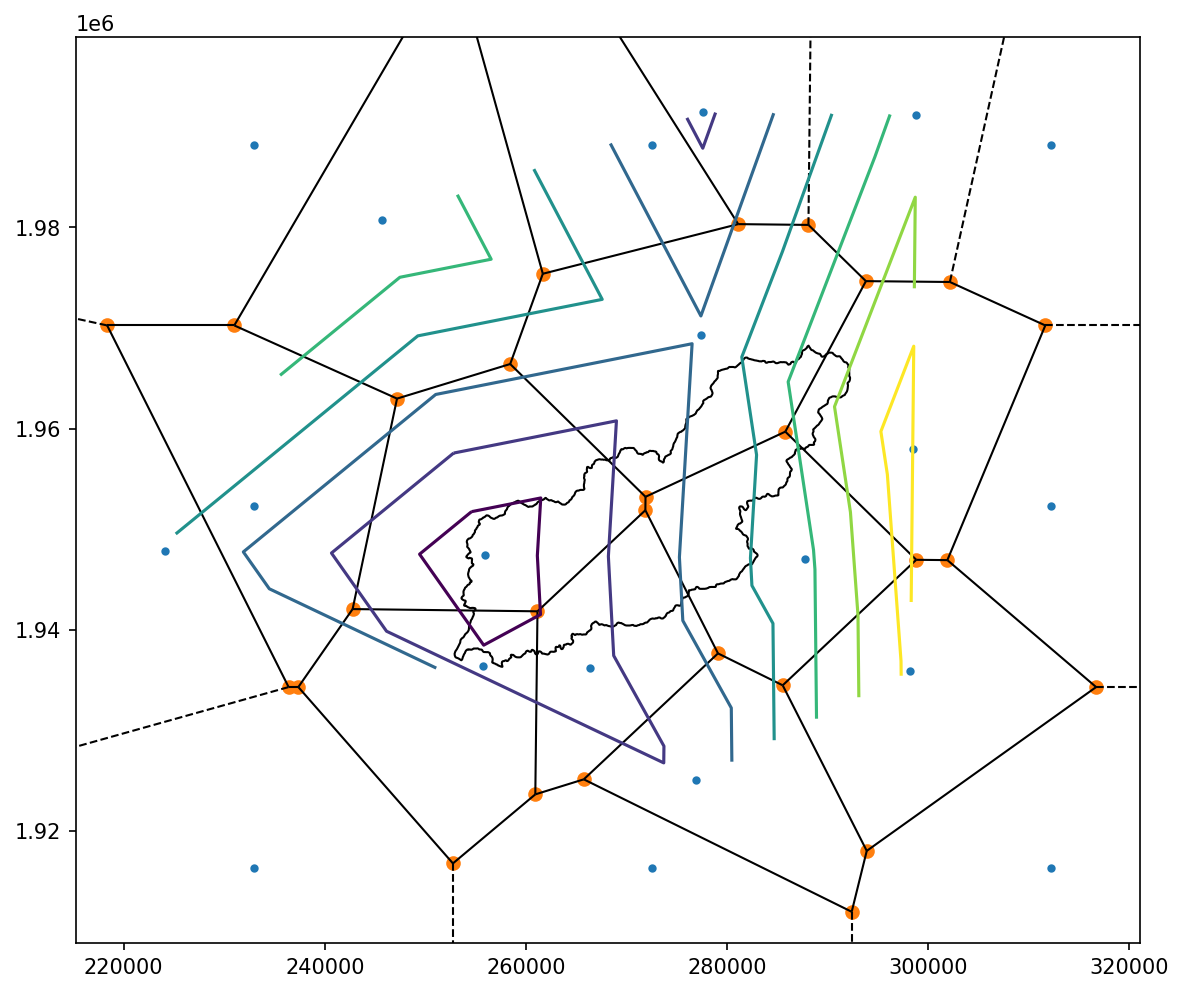

In [27]:
# Polígonos de Thiessen + isoyetas.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Graficamos las subcuenca.
Subcuenca.plot(ax = ax, color = "None", edgecolor = "k")
# Graficamos los polígonos de Thiessen.
spatial.voronoi_plot_2d(Thiessen, ax = ax)
# Graficamos las isoyetas.
df_is.plot("hp [mm]", ax = ax)

fig.tight_layout()
plt.show()

In [28]:
# Obtenemos la parte de la línea de cada isoyeta que cae dentro de la cuenca.
df_is[Subcuenca.loc[0, 'CVE_SUBCUE']] = df_is["geometry"
    ].intersection( Subcuenca.loc[0, "geometry"] )
subc_is = df_is.set_geometry(Subcuenca.loc[0, 'CVE_SUBCUE']).copy()

# Eliminamos las isoyetas que no curzan la subcuenca.
subc_is = subc_is[ ~ subc_is.is_empty ].reset_index(drop = True)

subc_is

,hp [mm],geometry,RH19Be
0,750.0,"LINESTRING (254600.335 1951727.829, 261489.590...","MULTILINESTRING ((258599.423 1952519.423, 2594..."
1,900.0,"LINESTRING (252818.374 1957557.481, 269017.432...","LINESTRING (268800.464 1957114.861, 268215.366..."
2,1050.0,"LINESTRING (251091.510 1936166.407, 234483.073...","LINESTRING (276103.776 1961011.034, 275282.251..."
3,1200.0,"LINESTRING (290458.091 1991306.894, 285542.802...","MULTILINESTRING ((281555.199 1966672.696, 2829..."
4,1350.0,"LINESTRING (296245.808 1991244.437, 294728.184...","LINESTRING (286825.851 1966526.871, 286100.848..."
5,1500.0,"LINESTRING (298656.347 1973948.302, 298747.581...","LINESTRING (292170.792 1965956.602, 291080.240..."


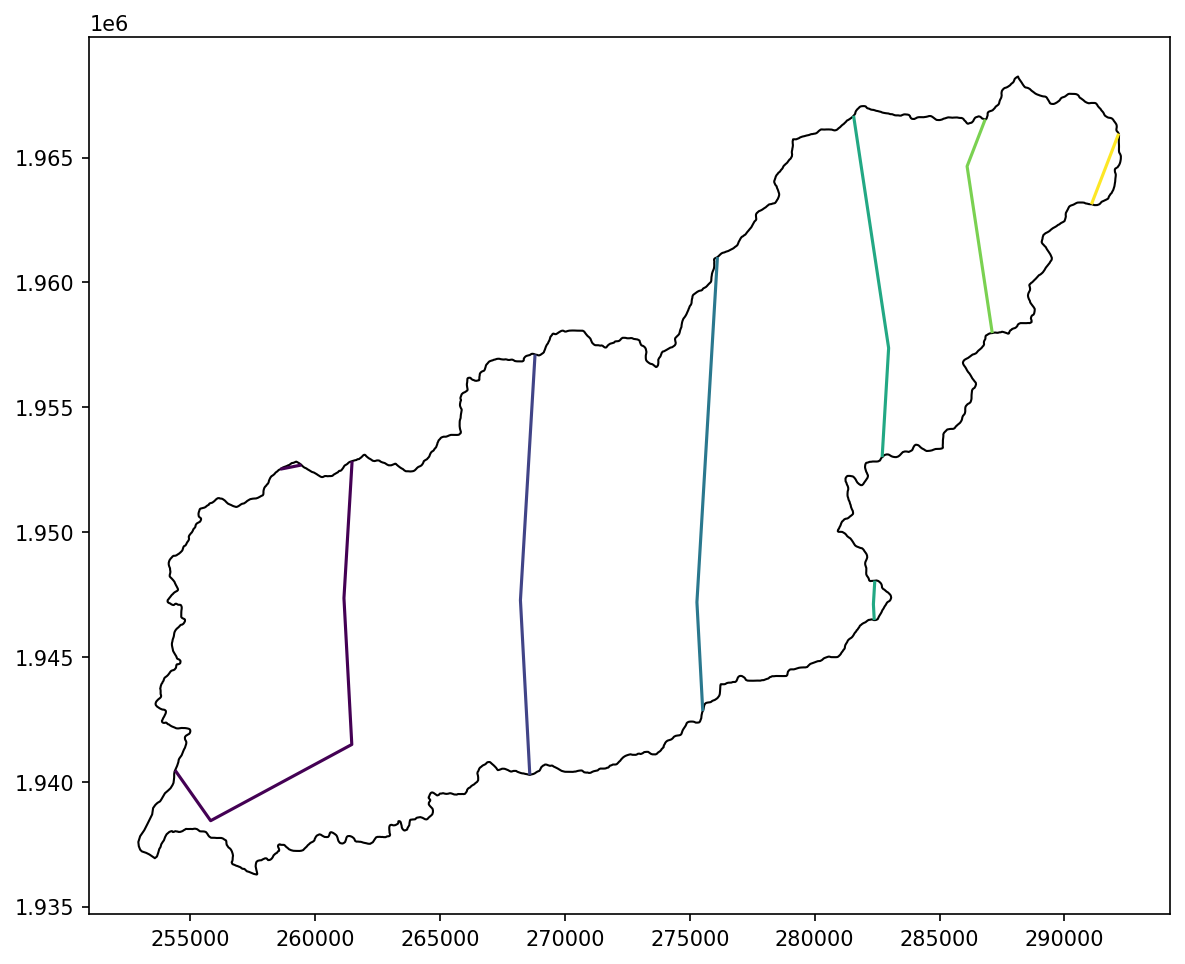

In [29]:
# Isoyetas que cruzan la cuenca.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Graficamos la subcuenca.
Subcuenca.plot(ax = ax, color = "None", edgecolor = "k")
# Graficamos las isoyetas.
subc_is.plot("hp [mm]", ax = ax)

fig.tight_layout()
plt.show()

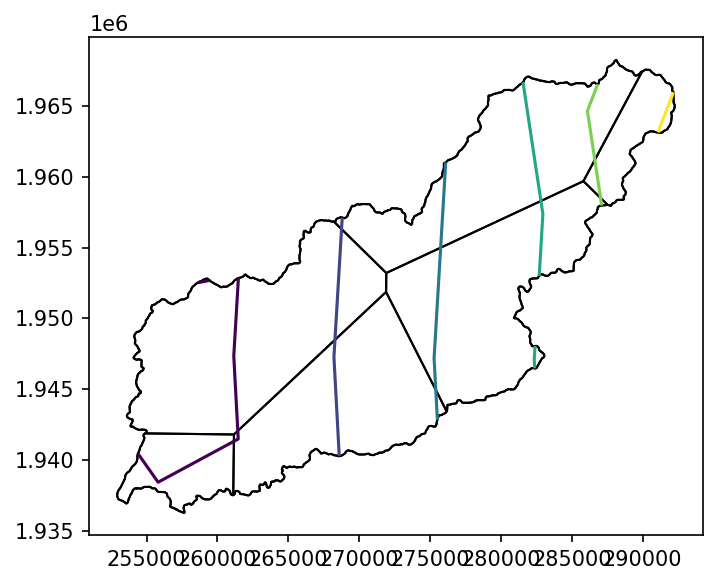

In [30]:
# Áreas de influencia e isoyetas que cruzan la cuenca.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 4)
fig.set_dpi(150) 

Subcuenca.plot(ax = ax, color = "None", edgecolor = "k")
# Áreas de influencia.
Estaciones.plot(ax = ax, color = "None", edgecolor = "k")
# Isoyetas que cruzan la cuenca.
subc_is.set_geometry(Subcuenca.loc[0, "CVE_SUBCUE"]).plot("hp [mm]", ax = ax)

fig.tight_layout()
plt.show()

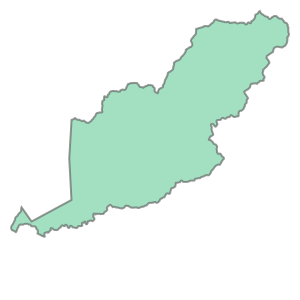

In [31]:
# Verificamos la geometría que hay que utilizar dentro del split
# para el área incremental de isoyetas.
i = 0
k = 0

shp.ops.split(Subcuenca.loc[0, "geometry"], subc_is.loc[i, "geometry"])[k]

In [32]:
# Área incremental de isoyetas.

# Geometrías a utilizar dentro del split para el área incremental de isoyetas.
j = [ [0, 2], [0], [0], [0, 2], [0], [0] ]
m = []

# Iteramos para todas las isoyetas.
for i in range(subc_is.shape[0]):

    g = []
    # Curva de la isoyeta.
    l = subc_is.loc[i, "geometry"]

    # Unimos todas las geometrías del área incremental isoyetas.
    for k in j[i]:
        g.append( shp.ops.split( Subcuenca.loc[0, "geometry"], l)[k] )

    # Agregamos la geometría.
    m.append( shp.geometry.MultiPolygon(g) )

# Agregamoslas geometrías creadas.
subc_is[f"{Subcuenca.loc[0, 'CVE_SUBCUE']}_POLY"] = m

subc_is

,hp [mm],geometry,RH19Be,RH19Be_POLY
0,750.0,"LINESTRING (254600.335 1951727.829, 261489.590...","MULTILINESTRING ((258599.423 1952519.423, 2594...",(POLYGON ((292114.7400555336 1964589.739102419...
1,900.0,"LINESTRING (252818.374 1957557.481, 269017.432...","LINESTRING (268800.464 1957114.861, 268215.366...",(POLYGON ((292114.7400555336 1964589.739102419...
2,1050.0,"LINESTRING (251091.510 1936166.407, 234483.073...","LINESTRING (276103.776 1961011.034, 275282.251...",(POLYGON ((292114.7400555336 1964589.739102419...
3,1200.0,"LINESTRING (290458.091 1991306.894, 285542.802...","MULTILINESTRING ((281555.199 1966672.696, 2829...",(POLYGON ((292114.7400555336 1964589.739102419...
4,1350.0,"LINESTRING (296245.808 1991244.437, 294728.184...","LINESTRING (286825.851 1966526.871, 286100.848...",(POLYGON ((292114.7400555336 1964589.739102419...
5,1500.0,"LINESTRING (298656.347 1973948.302, 298747.581...","LINESTRING (292170.792 1965956.602, 291080.240...",(POLYGON ((292114.7400555336 1964589.739102419...


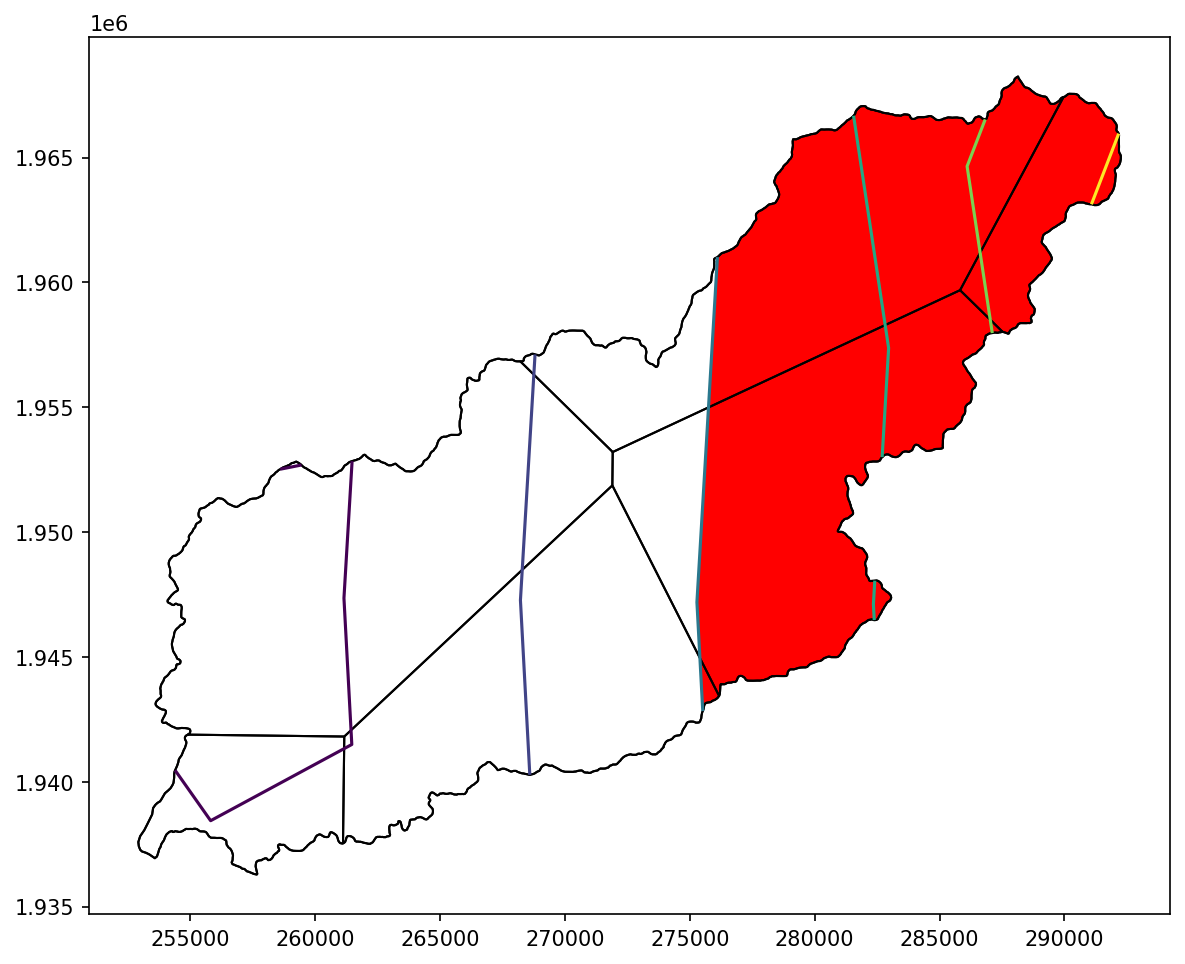

In [33]:
# Áreas de influencia + áreas incremental de isoyetas (Ci para h - a - d)

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

i = 2

# Graficamos la subcuenca.
Subcuenca.plot(ax = ax, color = "None", edgecolor = "k")
# Áreas de influencia.
Estaciones.plot(ax = ax, color = "None", edgecolor = "k")
# Graficamos las isoyetas.
subc_is.set_geometry(Subcuenca.loc[0, 'CVE_SUBCUE']).plot("hp [mm]", ax = ax)
# Áreas de isoyetas incrementales.
subc_is.set_geometry(f"{Subcuenca.loc[0, 'CVE_SUBCUE']}_POLY"
    ).loc[ [i] ].plot( ax = ax, color = "r", zorder = 0)

fig.tight_layout()
plt.show()

In [34]:
# Áreas de influencia para cada Ci, área incremental de isoyetas.

for i in subc_is.index:
    # La geometría es la intersección del área incremental de isoyeta Ci y los
    # polígonos de Thiessen dentro de la cuenca.
    subc_th[f"IS_{subc_is.index[i]}"] = subc_th[
        Subcuenca.loc[0, 'CVE_SUBCUE'] ].intersection(
        subc_is.loc[ i, f"{Subcuenca.loc[0, 'CVE_SUBCUE']}_POLY" ] )
    # Calculamos el área.
    subc_th[f"IS_{subc_is.index[i]}_AREA"] = subc_th[
        f"IS_{subc_is.index[i]}"].area

subc_th

,ESTACION,ESTADO,LONGITUD,LATITUD,HP_1980,geometry,x,y,Thiessen,RH19Be,...,IS_1,IS_1_AREA,IS_2,IS_2_AREA,IS_3,IS_3_AREA,IS_4,IS_4_AREA,IS_5,IS_5_AREA
0,PETATLAN,Guerrero,-101.3,17.5,926.0,POINT (255784.912 1936343.437),255784.911724,1.936343e+06,"POLYGON ((261161.516 1941814.357, 260946.342 1...","POLYGON ((261110.999 1937538.641, 261084.675 1...",...,POLYGON EMPTY,0.000000e+00,POLYGON EMPTY,0.000000e+00,POLYGON EMPTY,0.000000e+00,POLYGON EMPTY,0.000000e+00,POLYGON EMPTY,0.000000e+00
1,RANCHO NUEVO,Guerrero,-101.2,17.5,999.0,POINT (266407.362 1936217.934),266407.361726,1.936218e+06,"POLYGON ((271895.672 1951870.120, 279120.367 1...","POLYGON ((276170.804 1943441.832, 276142.063 1...",...,"POLYGON ((276142.063 1943403.408, 276103.074 1...",5.948938e+07,"POLYGON ((276142.063 1943403.408, 276103.074 1...",6.820051e+05,POLYGON EMPTY,0.000000e+00,POLYGON EMPTY,0.000000e+00,POLYGON EMPTY,0.000000e+00
3,CASAS VIEJAS,Guerrero,-101.0,17.6,1465.0,POINT (287767.080 1947052.354),287767.079912,1.947052e+06,"POLYGON ((271910.846 1953206.806, 285819.527 1...","POLYGON ((285819.527 1959687.285, 287524.662 1...",...,"POLYGON ((287524.662 1958018.354, 287500.371 1...",1.210838e+08,"POLYGON ((287524.662 1958018.354, 287500.371 1...",1.007354e+08,"MULTIPOLYGON (((287524.662 1958018.354, 287500...",2.033571e+07,"POLYGON ((287524.662 1958018.354, 287500.371 1...",1.136675e+05,POLYGON EMPTY,0.000000e+00
4,SAN ANTONIO TEJAS,Guerrero,-100.9,17.7,1903.0,POINT (298493.338 1958011.291),298493.338325,1.958011e+06,"POLYGON ((298844.879 1946938.485, 301940.642 1...","POLYGON ((285819.527 1959687.285, 289958.926 1...",...,"POLYGON ((289958.926 1967418.364, 289966.640 1...",2.549987e+07,"POLYGON ((289958.926 1967418.364, 289966.640 1...",2.549987e+07,"POLYGON ((289958.926 1967418.364, 289966.640 1...",2.549987e+07,"POLYGON ((289958.926 1967418.364, 289966.640 1...",2.411830e+07,"POLYGON ((292183.158 1965916.936, 292185.086 1...",1.202334e+06
6,LAS PILAS DEL RIO FRIO,Guerrero,-101.1,17.8,1217.0,POINT (277398.430 1969305.994),277398.429729,1.969306e+06,"POLYGON ((271910.846 1953206.806, 285819.527 1...","POLYGON ((285819.527 1959687.285, 271910.846 1...",...,"POLYGON ((271910.846 1953206.806, 268752.356 1...",1.178611e+08,"POLYGON ((275746.000 1954993.721, 276103.776 1...",9.286581e+07,"POLYGON ((282820.431 1958289.915, 281555.199 1...",4.384938e+07,"POLYGON ((286880.430 1966557.744, 286898.552 1...",1.164654e+07,POLYGON EMPTY,0.000000e+00
10,SAN JERONIMITO,Guerrero,-101.3,17.6,789.0,POINT (255918.987 1947413.887),255918.987305,1.947414e+06,"POLYGON ((271910.846 1953206.806, 258446.684 1...","POLYGON ((271910.846 1953206.806, 271895.672 1...",...,"POLYGON ((271895.672 1951870.120, 268287.657 1...",1.544858e+07,POLYGON EMPTY,0.000000e+00,POLYGON EMPTY,0.000000e+00,POLYGON EMPTY,0.000000e+00,POLYGON EMPTY,0.000000e+00


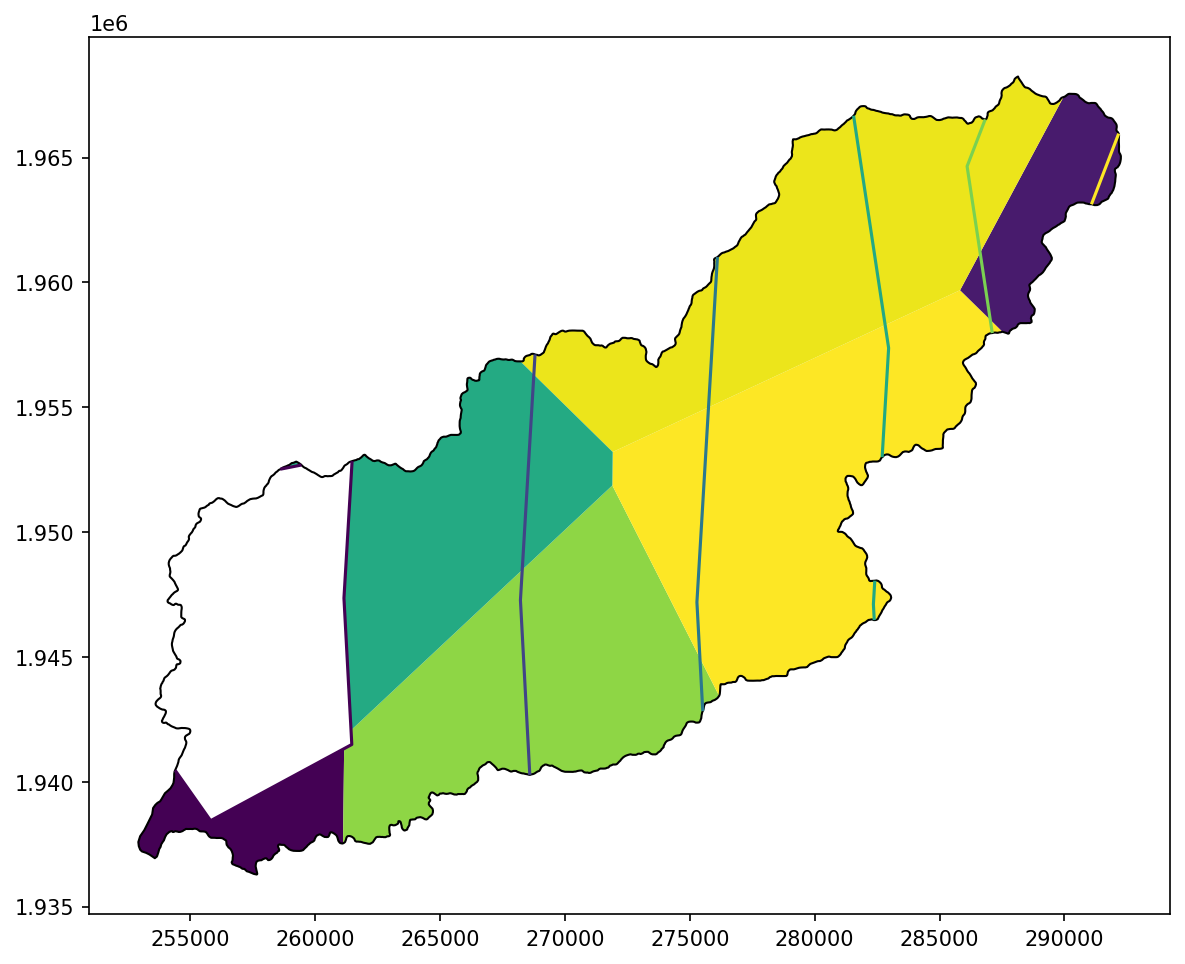

In [35]:
# Áreas de  influencia que caen en las áreas
# incrementales de isoyetas (Ci para h - a - d)

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

i = 0

# Graficamos la subcuenca.
Subcuenca.plot(ax = ax, color = "None", edgecolor = "k")
# Áreas de influencia dentro de cada Ci.
subc_th.set_geometry(f"IS_{i}").plot(f"IS_{i}_AREA", ax = ax, zorder = 0)
# Graficamos las isoyetas.
subc_is.set_geometry(Subcuenca.loc[0, "CVE_SUBCUE"]).plot("hp [mm]", ax = ax)

fig.tight_layout()
plt.show()

In [36]:
# Precipitación media por Thiessen.

# Creamos una lista con nombres de las isoyetas y sus áreas.
areas_n = ( [ Subcuenca.loc[0, 'CVE_SUBCUE'] ]
    + [ f"IS_{x}" for x in subc_is.index ] )
areas_na = [f"{x}_AREA" for x in areas_n]

# Precipitación media por Thiessen.
hp_th = []
for i in range( len(areas_na) ):
    hp_th.append( ( subc_th["HP_1980"] * subc_th[areas_na[i]] ).sum()
        / subc_th[areas_na[i]].sum() )

# Creamos un DataFrame con la precipitación media.
areas_is = pd.DataFrame( hp_th, columns = ["hp_th"],
    index = areas_n ).reset_index()
areas_is = areas_is.rename( {"index": "AREA"}, axis = 1)

areas_is

,AREA,hp_th
0,RH19Be,1129.554086
1,IS_0,1185.224912
2,IS_1,1299.328958
3,IS_2,1409.583579
4,IS_3,1468.281465
5,IS_4,1678.929526
6,IS_5,1903.000000


In [37]:
# Precipitación media por isoyetas.

# Áreas entre isoyetas.
# Diferencia entre el área de dos isoyetas contiguas.
# Los casos borde son ligeramente diferente (ejemplo: toda la subcuenca menos
# primer isoyeta).
m = []
for i in areas_is.index:
    if i == areas_is.index[-1]:
        p = subc_is.loc[i - 1, f"{areas_n[0]}_POLY"]
    elif i > 0:
        p = subc_is.loc[i - 1, f"{areas_n[0]}_POLY"
            ].difference( subc_is.loc[ i, f"{areas_n[0]}_POLY"] )
    else:
        p = Subcuenca.loc[0, "geometry"].difference(
            subc_is.loc[i, f"{areas_n[0]}_POLY"] )
    
    if type(p) == shp.geometry.polygon.Polygon: p = [p]
    m = ( [ shp.geometry.MultiPolygon( p ) ] + m )

# Agregamos las áreas entre isoyetas al DataFrame.
areas_is["IS_GEOM"] = m
areas_is = gpd.GeoDataFrame( areas_is, geometry = "IS_GEOM" )
areas_is["IS_AREA"] = areas_is.area

# Calculamos el paso entre cada isoyeta.
step = subc_is.at[ 1, "hp [mm]" ] - subc_is.at[ 0, "hp [mm]" ]
mid = step / 2

# Calculamos la precipitación entre isoyetas.
m = ( [subc_is.at[ 0, "hp [mm]" ] - mid ]
    + list(subc_is[ "hp [mm]" ] + mid) )

# Agregamos la precipitación entre isoyetas al DataFrame.
areas_is["hp_area"] = m

# Precipitación media por isoyetas.
m = []
for i in areas_is.index:
    m.append( ( areas_is.loc[i:, "hp_area"]
        * areas_is.loc[i:, "IS_AREA"] ).sum()
        / areas_is.loc[i:, "IS_AREA"].sum() )
areas_is["hp_is"] = m

# Factor de ajuste.
areas_is["Fa"] = areas_is["hp_is"] / areas_is["hp_th"]

areas_is

,AREA,hp_th,IS_GEOM,IS_AREA,hp_area,hp_is,Fa
0,RH19Be,1129.554086,"MULTIPOLYGON (((292114.740 1964589.739, 292074...",1.202334e+06,675.0,1259.934176,1.115426
1,IS_0,1185.224912,"MULTIPOLYGON (((291047.116 1963128.511, 290984...",3.467618e+07,825.0,1261.218229,1.064117
2,IS_1,1299.328958,"MULTIPOLYGON (((287105.365 1957969.899, 287038...",5.380644e+07,975.0,1290.702515,0.993361
3,IS_2,1409.583579,"MULTIPOLYGON (((282686.699 1952994.738, 282647...",1.300981e+08,1125.0,1327.692688,0.941904
4,IS_3,1468.281465,"MULTIPOLYGON (((275515.971 1942831.317, 275494...",1.195997e+08,1275.0,1407.813479,0.958817
5,IS_4,1678.929526,"MULTIPOLYGON (((268543.830 1940287.367, 268487...",1.276384e+08,1425.0,1483.624222,0.883673
6,IS_5,1903.000000,"MULTIPOLYGON (((254468.583 1940642.649, 254517...",8.188931e+07,1575.0,1575.000000,0.827641


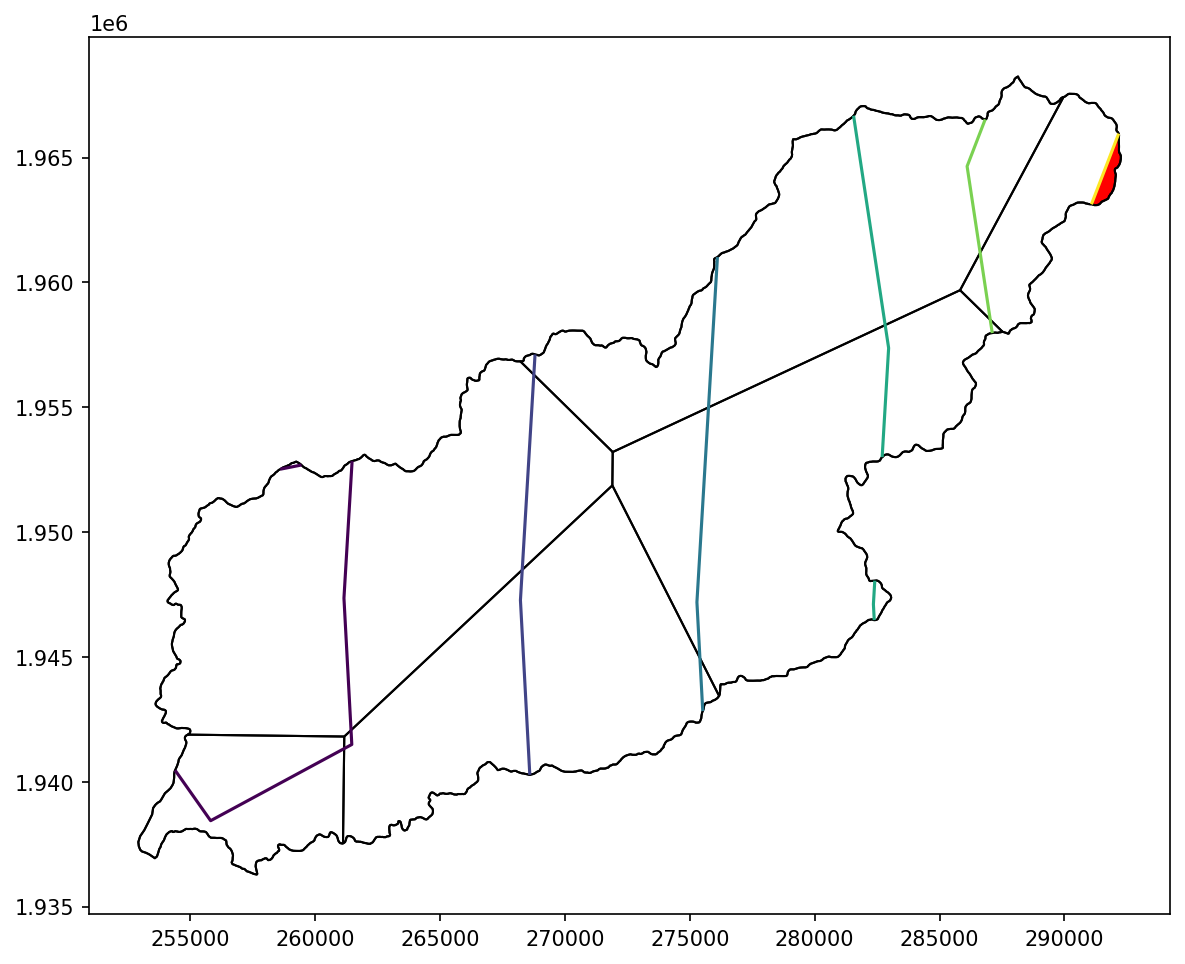

In [38]:
# Polígonos de Thiessen + areas entre isoyetas.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

i = 0

# Graficamos la subcuenca.
Subcuenca.plot(ax = ax, color = "None", edgecolor = "k")
# Graficamos los polígonos de Thiessen.
Estaciones.plot(ax = ax, color = "None", edgecolor = "k")
# Graficamos las isoyetas.
subc_is.set_geometry(Subcuenca.loc[0, "CVE_SUBCUE"]).plot("hp [mm]", ax = ax)
# Áreas las áreas entre isoyetas.
areas_is.loc[ [i] ].plot(ax = ax, color = "r", zorder = 0)

fig.tight_layout()
plt.show()

In [39]:
# Tarea.
# Para las estaciones de Baja California, escoger la tormenta
# que sucede el 1° de enero de 2023 entre la 1:30 y las 15:30,
# inclusive. Ajusta la precipitación de la Isla Coronado
# para que a la 1:30 se tenga 0 mm, a las 2:00 haya 0.2 mm,
# a las 3:00 haya 0.5 mm. Calcula la precipitación total de la tormenta
# para cada estación y las isoyetas.
# Grafica todas las subcuencas de la región hidrológica 1.
# Para la subcuenca que te indique el profesor, calcula
# las áreas incrementales de precipitación Ci y las áreas de influencia para
# cada Ci, y calcula la precipitación media por Thiessen e isoyetas, así como
# el factor de ajuste Fa para cada Ci.

In [40]:
# Examen.
# Calcula las curvas h - a - d para la tormenta de Baja California 
# en la subcuenca que te indicó el profesor.
# Se recomienda empezar calculando la curva masa media y 
# la tabla de duración para la subcuenca completa.
# Calcula la curva hipsométrica para la subcuenca que te indicó el profesor.
# Si tu subcuenca cuenta con más de 30 curvas de nivel,
# escoge solo las curvas cada 400 metros.
# La tabla de estaciones y de curvas de nivel está en WGS84 EPSG:4326.
# Trabaja las isoyetas y polígonos de Thiessen en coordenadas
# Cónica Conforme de Lambert ITRF2008 ESPSG:6372.
# Trabaja la curva hipsométrica en coordenadas UTM 11N ESPSG:32611.